In [1]:
import numpy as np
import math
import pandas as pd
import os
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython
from IPython.display import Audio
from IPython.display import Image

import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedGroupKFold
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold
import seaborn as sn
import sklearn
from sklearn.manifold import TSNE
from imblearn.metrics import sensitivity_specificity_support


In [2]:
DATA_PATH_Gita = os.path.abspath(os.getcwd()).split('Codigos')[0]+'Parkinson_datasets/Gita/Pataka'

SAMPLE_RATE = 44100
#AVPEPUDEAC0001_pataka
data_Gita = pd.DataFrame(columns=['Speaker_ID', 'Label', 'Path'])
Speaker_PD=0
Speaker_HC=50

for dirname, _, filenames in os.walk(DATA_PATH_Gita):
    
    for filename in filenames:
        file_path = os.path.join(dirname, filename)

        if dirname.find('PD')!=-1:
            Speaker_PD+=1
            Speaker_ID=Speaker_PD
            Label=1
        else: 
            Speaker_HC+=1
            Speaker_ID=Speaker_HC
            Label=0

            
        data_Gita=pd.concat([data_Gita, pd.DataFrame({"Speaker_ID": [Speaker_ID],
                            "Label": [Label],
                            "Path": [file_path]
                             })],ignore_index=True)
print("number of files is {}".format(len(data_Gita)))
data_Gita.head()

number of files is 100


,Speaker_ID,Label,Path
0,1,1,/home/byo/Documents/Experiments_EmiroIbarra/Pa...
1,2,1,/home/byo/Documents/Experiments_EmiroIbarra/Pa...
2,3,1,/home/byo/Documents/Experiments_EmiroIbarra/Pa...
3,4,1,/home/byo/Documents/Experiments_EmiroIbarra/Pa...
4,5,1,/home/byo/Documents/Experiments_EmiroIbarra/Pa...


In [3]:
DATA_PATH_NeuroV = os.path.abspath(os.getcwd()).split('Codigos')[0]+'Parkinson_datasets/BDatos Neurovoz/PorMaterial_limpios1_2_downsized/PATAKA'

SAMPLE_RATE = 44100
data_NeuroV = pd.DataFrame(columns=['Speaker_ID', 'Label', 'Path'])
for dirname, _, filenames in os.walk(DATA_PATH_NeuroV):
    for filename in filenames:
            file_path = os.path.join(dirname, filename)
            if filename.find('wav')!=-1:
                identifiers=filename.split('.')[0].split('_')
                Speaker_ID=int(identifiers[2])+100
                if identifiers[0]=='PD':
                    Label=1
                else:
                    Label=0
            data_NeuroV=pd.concat([data_NeuroV, pd.DataFrame({"Speaker_ID": [Speaker_ID],
                            "Label": [Label],
                            "Path": [file_path]
                             })],ignore_index=True)
print("number of files is {}".format(len(data_NeuroV)))
data_NeuroV.head()



number of files is 86


,Speaker_ID,Label,Path
0,169,1,/home/byo/Documents/Experiments_EmiroIbarra/Pa...
1,120,1,/home/byo/Documents/Experiments_EmiroIbarra/Pa...
2,137,1,/home/byo/Documents/Experiments_EmiroIbarra/Pa...
3,108,1,/home/byo/Documents/Experiments_EmiroIbarra/Pa...
4,209,1,/home/byo/Documents/Experiments_EmiroIbarra/Pa...


In [4]:
print('Data Gita')
print('Parkinson')
PD_Gita=data_Gita[data_Gita['Label']==1].sort_values(by=['Speaker_ID'])['Speaker_ID'].unique()
print(PD_Gita)
print('size=', PD_Gita.shape)
print('Control')
HC_Gita=data_Gita[data_Gita['Label']==0].sort_values(by=['Speaker_ID'])['Speaker_ID'].unique()
print(HC_Gita)
print('size=', HC_Gita.shape)

print('Data NeuroVoz')
print('Parkinson')
PD_NeuroV=data_NeuroV[data_NeuroV['Label']==1].sort_values(by=['Speaker_ID'])['Speaker_ID'].unique()
print(PD_NeuroV)
print('size=', PD_NeuroV.shape)
print('Control')
HC_NeuroV=data_NeuroV[data_NeuroV['Label']==0].sort_values(by=['Speaker_ID'])['Speaker_ID'].unique()
print(HC_NeuroV)
print('size=', HC_NeuroV.shape)



Data Gita
Parkinson
[1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50]
size= (50,)
Control
[51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74
 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98
 99 100]
size= (50,)
Data NeuroVoz
Parkinson
[106 107 108 109 110 111 112 113 115 116 117 118 119 120 124 125 127 128
 129 130 131 132 133 135 137 138 139 140 141 142 143 144 146 147 166 168
 169 170 177 209 211 213 215 217]
size= (44,)
Control
[134 136 148 149 151 152 153 154 155 156 160 161 162 163 164 172 174 175
 176 181 182 185 186 205 212 216 218 220 222 228 230 231 232 234 236 237
 238 240 241 242 243 245]
size= (42,)


In [5]:
#Partition Gita
Train_Subject_Gita=np.concatenate([PD_Gita, HC_Gita])

print("Data Gita")
print("To test:",np.unique(Train_Subject_Gita).shape)
data_test_Gita=data_Gita

#Partition NeuroVoz

Train_Subject_NeuroV=np.concatenate([PD_NeuroV, HC_NeuroV])
print("Data NeuroVoz")
print("To train:",np.unique(Train_Subject_NeuroV).shape)
data_train_NeuroV=data_NeuroV



Data Gita
To test: (100,)
Data NeuroVoz
To train: (86,)


In [6]:
#selecting 400ms overlap in 50ms of audio signal example
def process_select_signals(data, SAMPLE_RATE):
    time_leng=0.4
    sample_leng=int(time_leng*SAMPLE_RATE)
    overloap=2
    signals, y_label, subject_group, tono =[],[],[],[]


    #Processs data to train
    for data_ind, file_path in enumerate(data.Path):
        audio, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
        audio_len=len(audio)
        #print(file_path)
        #plt.plot(audio)
        audio=audio/np.max(abs(audio))
        indx=[i for i,x in enumerate(np.sqrt(abs(audio))) if x>.30]
        segments=0
        if (indx[0]+sample_leng)<audio_len:
            for i in range(int((-indx[0]+indx[len(indx)-1])/(sample_leng/overloap))):
                ind_start = i * int(sample_leng/overloap)+indx[0]
                ind_end = ind_start + sample_leng
                if ind_end <= indx[len(indx)-1]:
                    signal=np.zeros(sample_leng)
                    signal = audio[ind_start:int(ind_end)]
                    signals.append(signal)
            
                    y_label.append(data.iloc[data_ind]['Label'])
                    subject_group.append(data.iloc[data_ind]['Speaker_ID'])
                    segments=segments+1
            print(" Processed {}/{} files".format(data.iloc[data_ind]['Speaker_ID'],len(data)-1),end='')
            print(" Time audio: {} Segments {} ".format((audio_len-1)/sample_rate,segments))
        else:
             print(" Processed {}/{} files".format(data.iloc[data_ind]['Speaker_ID'],len(data)-1),end='')
             print(" Time audio: {} Segments {} ".format((audio_len-1)/sample_rate,0))
    signals = np.stack(signals,axis=0)
    y_label = np.stack(y_label,axis=0)
    subject_group = np.stack(subject_group,axis=0)
    return signals, y_label, subject_group

In [7]:
signals_test_Gita, y_label_test_Gita, subject_group_test_Gita = process_select_signals(data_test_Gita, SAMPLE_RATE)
print('size data train', signals_test_Gita.shape)

signals_train_NeuroV, y_label_train_NeuroV, subject_group_train_NeuroV = process_select_signals(data_train_NeuroV, SAMPLE_RATE)
print('size data train', signals_train_NeuroV.shape)



 Processed 1/99 files Time audio: 2.519614512471655 Segments 10 
 Processed 2/99 files Time audio: 5.553083900226757 Segments 25 
 Processed 3/99 files Time audio: 1.9452380952380952 Segments 7 
 Processed 4/99 files Time audio: 2.5204761904761903 Segments 9 
 Processed 5/99 files Time audio: 4.17984126984127 Segments 19 
 Processed 6/99 files Time audio: 1.4207709750566893 Segments 5 
 Processed 7/99 files Time audio: 3.325034013605442 Segments 14 
 Processed 8/99 files Time audio: 4.467210884353742 Segments 20 
 Processed 9/99 files Time audio: 1.7343990929705215 Segments 7 
 Processed 10/99 files Time audio: 2.5707482993197277 Segments 11 
 Processed 11/99 files Time audio: 2.364512471655329 Segments 10 
 Processed 12/99 files Time audio: 6.068208616780045 Segments 28 
 Processed 13/99 files Time audio: 6.52859410430839 Segments 30 
 Processed 14/99 files Time audio: 2.7931519274376417 Segments 12 
 Processed 15/99 files Time audio: 4.131632653061224 Segments 19 
 Processed 16/99 fi

 Processed 128/85 files Time audio: 13.091814058956917 Segments 64 
 Processed 168/85 files Time audio: 6.251111111111111 Segments 29 
 Processed 110/85 files Time audio: 7.265124716553288 Segments 35 
 Processed 130/85 files Time audio: 11.032675736961451 Segments 53 
 Processed 139/85 files Time audio: 8.51047619047619 Segments 41 
 Processed 140/85 files Time audio: 7.806507936507937 Segments 37 
 Processed 132/85 files Time audio: 6.925215419501134 Segments 33 
 Processed 115/85 files Time audio: 8.445668934240363 Segments 40 
 Processed 117/85 files Time audio: 12.863718820861678 Segments 62 
 Processed 143/85 files Time audio: 14.73766439909297 Segments 72 
 Processed 113/85 files Time audio: 14.364671201814058 Segments 70 
 Processed 146/85 files Time audio: 10.024807256235828 Segments 48 
 Processed 215/85 files Time audio: 6.00172335600907 Segments 28 
 Processed 142/85 files Time audio: 16.683718820861678 Segments 82 
 Processed 177/85 files Time audio: 11.23702947845805 Segm

In [8]:
def compute_norm_spect(signals, sample_rate):
    n_fft = 2048
    win_length = int(0.015*sample_rate) 
    hop_length = int(0.010*sample_rate)
    n_mels = 65 

    mel_spectrogram = T.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
        center=True,
        pad_mode="reflect",
        power=2.0,
        norm="slaney",
        onesided=True,
        n_mels=n_mels,
        mel_scale="htk",
    )


    mel_spectrograms = []
    scaler = StandardScaler()
    print("Calculating mel spectrograms")
    for i in range(signals.shape[0]):
        mel_spect = librosa.power_to_db(mel_spectrogram(torch.from_numpy(signals[i,:])))
        mel_spect_norm=scaler.fit_transform(mel_spect)
        mel_spectrograms.append(mel_spect_norm)
        print("\r Processed {}/{} files".format(i,signals.shape[0]),end='')
    mel_spectrograms = np.stack(mel_spectrograms,axis=0)
    print(' ')
    return mel_spectrograms


In [9]:
mel_spectrograms_test_Gita=compute_norm_spect(signals_test_Gita, SAMPLE_RATE)
print('Data size:',mel_spectrograms_test_Gita.shape)

mel_spectrograms_train_NeuroV=compute_norm_spect(signals_train_NeuroV, SAMPLE_RATE)
print('Data size:',mel_spectrograms_train_NeuroV.shape)




Calculating mel spectrograms
 Processed 210/1962 files

/usr/local/anaconda3/lib/python3.10/site-packages/torchaudio/transforms/_transforms.py:611: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(


 Processed 1961/1962 files 
Data size: (1962, 65, 41)
Calculating mel spectrograms
 Processed 135/4985 files

/usr/local/anaconda3/lib/python3.10/site-packages/torchaudio/transforms/_transforms.py:611: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(


 Processed 4984/4985 files 
Data size: (4985, 65, 41)


In [10]:
class CNN(nn.Module):
        
        def __init__(self, kernel_size_1=8, kernel_size_2=9, depth_CL=64, neurons_MLP=64, drop_out=0.2):
            super().__init__()
            
            # 1. conv block
            self.conv2Dblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1,
                       out_channels=depth_CL,
                       kernel_size=kernel_size_1,
                       stride=1,
                       padding=1
                      ),
            nn.BatchNorm2d(depth_CL),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=drop_out),
            )
            
            # 2. conv block
            self.conv2Dblock2 = nn.Sequential(
            nn.Conv2d(in_channels=depth_CL,
                       out_channels=depth_CL,
                       kernel_size=kernel_size_2,
                       stride=1,
                       padding=1
                      ),
            nn.BatchNorm2d(depth_CL),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=drop_out),
            
            )
        
            self.MLP = nn.Sequential(
                nn.Linear(depth_CL*math.ceil((math.ceil((65-kernel_size_1)/2+1)-kernel_size_2)/2+1)
                          *math.ceil((math.ceil((41-kernel_size_1)/2+1)-kernel_size_2)/2+1),neurons_MLP),
            nn.ReLU(),
            nn.Dropout(p=drop_out),
            )
            
            self.out_softmax = nn.Sequential(
                nn.Linear(neurons_MLP,2),
                nn.Softmax(dim=1)
            )
            

        def forward(self,x):
            x = self.conv2Dblock1(x) 
            conv_embedding = self.conv2Dblock2(x) 
            conv_embedding = torch.flatten(conv_embedding, start_dim=1) 
            MPL_output = self.MLP(conv_embedding)
            output_softmax = self.out_softmax(MPL_output)
            return output_softmax, MPL_output

In [11]:
def reset_weights(m):
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

def soft_output_by_subject(output_test, Y_test, subject_group_test, ):

    Y_test_bySubject= []
    output_test_bySubjects=torch.empty((1,2),device=output_test.device.type)
    subject_in_group=np.unique(subject_group_test)
    output_test_subject=torch.zeros(subject_in_group.shape)
    Y_estimated_test_subject=torch.ones(subject_in_group.shape)
    for i, speaker in enumerate(subject_in_group):
        index_speaker = np.where(subject_group_test==speaker)
        output_test_subject[i]=torch.mean(torch.log(output_test[index_speaker][:,1]) -torch.log(output_test[index_speaker][:,0]),0)
        Y_test_bySubject.append(Y_test[index_speaker][0])
        
            
    Y_test_tensor_bySubject = torch.tensor(Y_test_bySubject,dtype=torch.long,device=device)
    Y_estimated_test_subject[output_test_subject<0]=0
    return output_test_subject , Y_test_tensor_bySubject,Y_estimated_test_subject

In [12]:
sgkf = StratifiedGroupKFold(n_splits=10)

Data_NeuroV_strat=sgkf.split(mel_spectrograms_train_NeuroV, y_label_train_NeuroV, subject_group_train_NeuroV)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

if device=='cuda':
    torch.cuda.set_device(1)

BATCH_SIZE = 64

   
#Data to test Gita
X_test_Gita =np.expand_dims(np.stack(mel_spectrograms_test_Gita, axis=0),1)
Y_test_Gita= y_label_test_Gita
X_test_tensor_Gita = torch.tensor(X_test_Gita,device=device).float()
Y_test_tensor_Gita = torch.tensor(Y_test_Gita,dtype=torch.long,device=device)


results_val_metric_subject_NeuroV  = [] 
Subject_Sen_spe_NeuroV, Subject_f1_score_NeuroV, Subject_MCC_NeuroV, Subject_AUC_NeuroV=[],[],[],[]
Subject_fpr_NeuroV, Subject_tpr_NeuroV=[],[]
results_loss_Epochs, results_metric_Epochs= [], []
results_val_metric_NeuroV_Epochs, results_val_loss_NeuroV_Epochs=[],[]
val_windows_metrics_NeuroV,    val_subject_metrics_NeuroV=[],[]
test_windows_metrics_Gita, test_subject_metrics_Gita=[],[] 


for k in range(10):  

    results_loss, results_metric, results_val_metric_NeuroV, results_val_loss_NeuroV,  = [], [], [], [] 
    print('')
    
    print(f"\k-fold {k + 1} \n***********************")
     
    train_index_NeuroV, val_index_NeuroV =next(iter(Data_NeuroV_strat))
    
    
    print(np.unique(subject_group_train_NeuroV[val_index_NeuroV]))
    
    #Data to train 
    X_train=np.expand_dims(np.stack(mel_spectrograms_train_NeuroV[train_index_NeuroV,:,:], axis=0),1)
    Y_train=y_label_train_NeuroV[train_index_NeuroV]
    X_tensor = torch.tensor(X_train,device=device).float()
    Y_tensor = torch.tensor(Y_train, dtype=torch.long,device=device)
    subject_group_train=subject_group_train_NeuroV[train_index_NeuroV]
    
    
    #Data to val NeuroV
    X_val_NeuroV =np.expand_dims(np.stack(mel_spectrograms_train_NeuroV[val_index_NeuroV,:,:], axis=0),1)
    Y_val_NeuroV= y_label_train_NeuroV[val_index_NeuroV]
    subject_group_val_NeuroV=subject_group_train_NeuroV[val_index_NeuroV]
    X_val_tensor_NeuroV = torch.tensor(X_val_NeuroV,device=device).float()
    Y_val_tensor_NeuroV = torch.tensor(Y_val_NeuroV,dtype=torch.long,device=device)
 
    
    DATASET_SIZE=X_train.shape[0]
    iters = int(DATASET_SIZE / BATCH_SIZE)

    model = CNN().to(device)
    model.apply(reset_weights)
    
    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(),lr=0.1)
    lambda1 = lambda epoch: 0.95 ** epoch
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

    
    dataset=TensorDataset(X_tensor,Y_tensor)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    for epoch in range(200):
        epoch_acc = 0
        epoch_loss = 0
        for id_batch, (x_batch, y_batch) in enumerate(dataloader):
            actual_batch_size=x_batch.shape[0]
                
            # zero the parameter gradients
            model.train()
            optimizer.zero_grad()

            # forward
            outputs = model(x_batch)[0]
            
            # calculate accuracy
            prediction = torch.max(outputs, 1)[1]
            metric = sklearn.metrics.accuracy_score(y_batch.data.cpu(), prediction.data.cpu())*100

                
            # calculate loss + backward + optimize
            loss = loss_func(outputs, y_batch)
            loss.backward()
            optimizer.step()
                
            epoch_acc += metric*actual_batch_size/DATASET_SIZE
            epoch_loss += loss.item()*actual_batch_size/DATASET_SIZE
        print(f"\r Epoch {epoch +1}: iteration {id_batch +1}/{iters} Acc_class: {epoch_acc:.2f}",end='')
            
        
        scheduler.step() 
        with torch.no_grad(): 
            model.eval() 
            output_val_NeuroV = model(X_val_tensor_NeuroV)[0]
            prediction_val_NeuroV = torch.max(output_val_NeuroV, 1)[1]
            val_metric_NeuroV = sklearn.metrics.accuracy_score(Y_val_tensor_NeuroV.data.cpu(), prediction_val_NeuroV.data.cpu())*100
            val_loss_NeuroV = loss_func(output_val_NeuroV, Y_val_tensor_NeuroV.data)
            
            output_val_bySubjects_NeuroV, Y_val_tensor_bySubject_NeuroV, prediction_val_bySubject_NeuroV =soft_output_by_subject(output_val_NeuroV, Y_val_NeuroV, subject_group_val_NeuroV)
            val_metric_subject_NeuroV = sklearn.metrics.accuracy_score(Y_val_tensor_bySubject_NeuroV.data.cpu(), prediction_val_bySubject_NeuroV.data.cpu())*100

        
           
        # append history
        results_loss.append(epoch_loss)
        results_metric.append(epoch_acc)
        results_val_metric_NeuroV.append(val_metric_NeuroV)
        results_val_metric_subject_NeuroV.append(val_metric_subject_NeuroV)
        results_val_loss_NeuroV.append(val_loss_NeuroV.item())
        
    
    print('')
    print(f"\r validation NeuroV: {val_metric_NeuroV:.2f} % by Subject: {val_metric_subject_NeuroV:.2f}%  ")
    
    #compute metrics 
    Sen_spe_subject_NeuroV=sensitivity_specificity_support(Y_val_tensor_bySubject_NeuroV.data.cpu(), prediction_val_bySubject_NeuroV.data.cpu(), average='binary')
    val_f1_score_NeuroV = sklearn.metrics.f1_score(Y_val_tensor_bySubject_NeuroV.data.cpu(), prediction_val_bySubject_NeuroV.data.cpu())*100
    val_MCC_NeuroV = sklearn.metrics.matthews_corrcoef(Y_val_tensor_bySubject_NeuroV.data.cpu(), prediction_val_bySubject_NeuroV.data.cpu())
    val_fpr_NeuroV, val_tpr_NeuroV, _ = sklearn.metrics.roc_curve(Y_val_tensor_bySubject_NeuroV.data.cpu(), output_val_bySubjects_NeuroV.data.cpu())
    val_AUC_NeuroV = sklearn.metrics.auc(val_fpr_NeuroV, val_tpr_NeuroV)
    
    
    with torch.no_grad(): 
        model.eval() 
        output_test_Gita, output_CNN_Gita  = model(X_test_tensor_Gita)
        prediction_test_Gita = torch.max(output_test_Gita, 1)[1]
    
    test_metric_Gita = sklearn.metrics.accuracy_score(Y_test_tensor_Gita.data.cpu(), prediction_test_Gita.data.cpu())*100
    
    output_test_bySubjects_Gita, Y_test_tensor_bySubject_Gita, prediction_test_bySubject_Gita =soft_output_by_subject( output_test_Gita, Y_test_Gita, subject_group_test_Gita)
    test_metric_subject_Gita = sklearn.metrics.accuracy_score(Y_test_tensor_bySubject_Gita.data.cpu(), prediction_test_bySubject_Gita.data.cpu())*100

    results_loss_Epochs.append(results_loss)
    results_metric_Epochs.append(results_metric)
    results_val_metric_NeuroV_Epochs.append(results_val_metric_NeuroV)
    results_val_loss_NeuroV_Epochs.append(results_val_loss_NeuroV)
    
    val_windows_metrics_NeuroV.append(val_metric_NeuroV)
    val_subject_metrics_NeuroV.append(val_metric_subject_NeuroV)  
    Subject_Sen_spe_NeuroV.append([Sen_spe_subject_NeuroV[0]*100, Sen_spe_subject_NeuroV[1]*100]) 
    Subject_f1_score_NeuroV.append(val_f1_score_NeuroV)
    Subject_MCC_NeuroV.append(val_MCC_NeuroV)
    Subject_AUC_NeuroV.append(val_AUC_NeuroV)
    Subject_fpr_NeuroV.append(val_fpr_NeuroV)
    Subject_tpr_NeuroV.append(val_tpr_NeuroV)

    test_windows_metrics_Gita.append(test_metric_Gita)
    test_subject_metrics_Gita.append(test_metric_subject_Gita) 
    torch.save(model.state_dict(), 'CNN_NeuroV_fold_'+str(k)+'.pt')
    
    


\k-fold 1 
***********************
[111 119 144 156 166 169 237 240 245]
 Epoch 200: iteration 70/69 Acc_class: 99.58
 validation NeuroV: 86.25 % by Subject: 88.89%  

\k-fold 2 
***********************
[125 127 130 140 164 182 186 230 234]
 Epoch 200: iteration 71/70 Acc_class: 99.60
 validation NeuroV: 87.07 % by Subject: 88.89%  

\k-fold 3 
***********************
[129 133 137 170 175 177 205 238 242]
 Epoch 200: iteration 71/70 Acc_class: 99.62
 validation NeuroV: 79.00 % by Subject: 66.67%  

\k-fold 4 
***********************
[115 118 135 147 151 162 231 232]
 Epoch 200: iteration 71/70 Acc_class: 99.56
 validation NeuroV: 92.65 % by Subject: 100.00%  

\k-fold 5 
***********************
[108 128 131 143 152 153 163 236 241]
 Epoch 200: iteration 70/70 Acc_class: 99.55
 validation NeuroV: 88.12 % by Subject: 88.89%  

\k-fold 6 
***********************
[106 117 136 142 146 148 149 168 176]
 Epoch 200: iteration 70/69 Acc_class: 99.73
 validation NeuroV: 55.99 % by Subject: 55.5

In [13]:
print(f'NeuroV: Accuracy:    {np.mean(val_subject_metrics_NeuroV):.2f} ({np.std(val_subject_metrics_NeuroV):.2f})%') 
print(f"\r      Sensitivity: {np.mean(np.stack(Subject_Sen_spe_NeuroV,0),0)[0]:.2f} ({np.std(np.stack(Subject_Sen_spe_NeuroV,0),0)[0]:.2f})% ")
print(f"\r      Specifity:   {np.mean(np.stack(Subject_Sen_spe_NeuroV,0),0)[1]:.2f} ({np.std(np.stack(Subject_Sen_spe_NeuroV,0),0)[1]:.2f})% ")
print(f'\r      f1_score:    {np.mean(Subject_f1_score_NeuroV):.2f} ({np.std(Subject_f1_score_NeuroV):.2f})%') 
print(f'\r      MCC:         {np.mean(Subject_MCC_NeuroV):.2f} ({np.std(Subject_MCC_NeuroV):.2f})') 
print(f'\r      AUC:         {np.mean(Subject_AUC_NeuroV):.2f} ({np.std(Subject_AUC_NeuroV):.2f})') 


print('')
print(f'Gita: Accuracy:  {np.mean(test_subject_metrics_Gita):.2f} ({np.std(test_subject_metrics_Gita):.2f})%') 

    

NeuroV: Accuracy:    80.14 (16.71)%
      Sensitivity: 80.50 (27.24)% 
      Specifity:   81.00 (14.80)% 
      f1_score:    78.56 (20.86)%
      MCC:         0.63 (0.33)
      AUC:         0.91 (0.14)

Gita: Accuracy:  56.30 (2.65)%


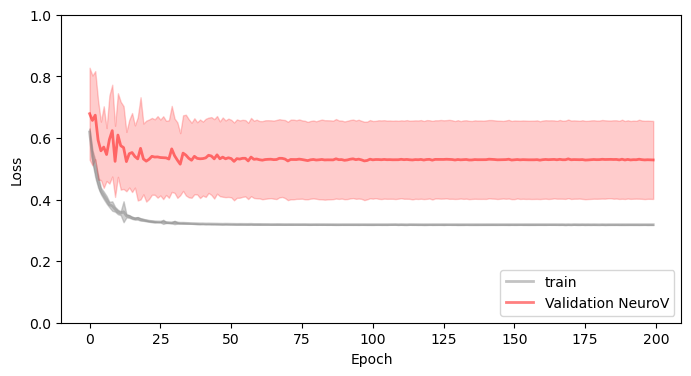

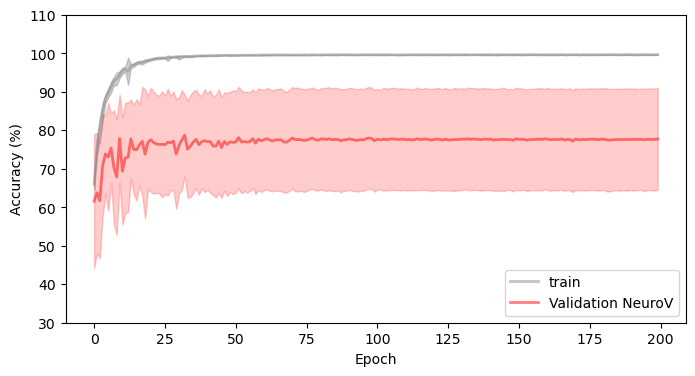

In [14]:
results_loss_Epochs_mean=np.stack(results_loss_Epochs,0).mean(axis=0)
results_loss_Epochs_std=np.stack(results_loss_Epochs,0).std(axis=0)

results_val_loss_NeuroV_Epochs_mean=np.stack(results_val_loss_NeuroV_Epochs,0).mean(axis=0)
results_val_loss_NeuroV_Epochs_std=np.stack(results_val_loss_NeuroV_Epochs,0).std(axis=0)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(range(epoch+1),results_loss_Epochs_mean, alpha=0.5, color='#888888', label='train', linewidth = 2.0)
ax.fill_between(range(epoch+1), results_loss_Epochs_mean - results_loss_Epochs_std, results_loss_Epochs_mean + results_loss_Epochs_std, color='#888888', alpha=0.4)

ax.plot(range(epoch+1),results_val_loss_NeuroV_Epochs_mean, alpha=0.5, color='red', label='Validation NeuroV', linewidth = 2.0)
ax.fill_between(range(epoch+1), results_val_loss_NeuroV_Epochs_mean - results_val_loss_NeuroV_Epochs_std, results_val_loss_NeuroV_Epochs_mean + results_val_loss_NeuroV_Epochs_std, color='red', alpha=0.2)


ax.set_ylim([0,1])
ax.legend(loc='lower right')
ax.set_ylabel("Loss")
ax.set_xlabel("Epoch")
plt.savefig("Loss_Train_Validation.pdf", dpi=150)

results_metric_Epochs_mean=np.stack(results_metric_Epochs,0).mean(axis=0)
results_metric_Epochs_std=np.stack(results_metric_Epochs,0).std(axis=0)


results_val_metric_NeuroV_Epochs_mean=np.stack(results_val_metric_NeuroV_Epochs,0).mean(axis=0)
results_val_metric_NeuroV_Epochs_std=np.stack(results_val_metric_NeuroV_Epochs,0).std(axis=0)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(range(epoch+1),results_metric_Epochs_mean, alpha=0.5, color='#888888', label='train', linewidth = 2.0)
ax.fill_between(range(epoch+1), results_metric_Epochs_mean - results_metric_Epochs_std, results_metric_Epochs_mean + results_metric_Epochs_std, color='#888888', alpha=0.4)


ax.plot(range(epoch+1),results_val_metric_NeuroV_Epochs_mean, alpha=0.5, color='red', label='Validation NeuroV', linewidth = 2.0)
ax.fill_between(range(epoch+1), results_val_metric_NeuroV_Epochs_mean - results_val_metric_NeuroV_Epochs_std, results_val_metric_NeuroV_Epochs_mean + results_val_metric_NeuroV_Epochs_std, color='red', alpha=0.2)


ax.set_ylim([30,110])
ax.legend(loc='lower right')

ax.set_ylabel("Accuracy (%)")
ax.set_xlabel("Epoch")
plt.savefig("Accuracy_Train_Validation.pdf", dpi=150)

In [15]:
print(f'NeuroV: Accuracy by windows:, {np.mean(val_windows_metrics_NeuroV):.2f} ({np.std(val_windows_metrics_NeuroV):.2f})%,Accuracy by subject:{np.mean(val_subject_metrics_NeuroV):.2f} ({np.std(val_subject_metrics_NeuroV):.2f})') 
print(f'Test Gita: Accuracy by windows:, {np.mean(test_windows_metrics_Gita):.2f} ({np.std(test_windows_metrics_Gita):.2f})%,Accuracy by subject:{np.mean(test_subject_metrics_Gita):.2f} ({np.std(test_subject_metrics_Gita):.2f})') 


NeuroV: Accuracy by windows:, 77.71 (13.18)%,Accuracy by subject:80.14 (16.71)
Test Gita: Accuracy by windows:, 56.40 (2.58)%,Accuracy by subject:56.30 (2.65)


In [16]:
def plot_ROC_k_fold(fpr_k_folds,tpr_k_folds,auc_k_folds,folds, color):
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    tprs=[]
    for k in range(folds):
        #display = sklearn.metrics.RocCurveDisplay(fpr=fpr_k_folds[k], tpr=tpr_k_folds[k], roc_auc=auc_k_folds[k],
        #                           estimator_name='ROC fold'+str(k))
        #display.plot()
    
        interp_tpr = np.interp(mean_fpr, fpr_k_folds[k], tpr_k_folds[k])
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc =np.mean(auc_k_folds)
    std_auc = np.std(auc_k_folds)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color=color,
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color=color,
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
       # title=f"Mean ROC curve with variability\n(Positive label '{target_names[1]}')",
    )
    ax.axis("square")
    ax.legend(loc="lower right")
    plt.show()

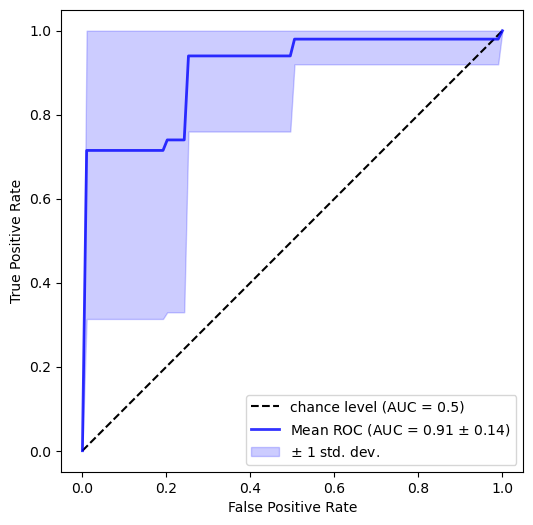

/usr/local/anaconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


In [17]:
plot_ROC_k_fold(Subject_fpr_NeuroV,Subject_tpr_NeuroV,Subject_AUC_NeuroV, 10, 'blue')
df=pd.DataFrame({'Subject_fpr_NeuroV':np.transpose(Subject_fpr_NeuroV),'Subject_tpr_NeuroV':np.transpose(Subject_tpr_NeuroV),
                 'Subject_AUC_NeuroV':np.transpose(Subject_AUC_NeuroV) }) 
df.to_csv('CNN_NeuroV_fpr_tpr_AUC_vowel.csv')  